## Export diagnostic videos

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import shutil


### define data paths

In [3]:
def make_labeled_video(
    save_file, cap, points, labels=None, likelihood_thresh=0.05, framerate=20, height=4):
    """Behavioral video overlaid with markers.

    Parameters
    ----------
    save_file
    cap : cv2.VideoCapture object
    points : list of dicts
        keys of marker names and vals of marker values,
        i.e. `points['paw_l'].shape = (n_t, 3)`
    labels : list of strs
        name for each model in `points`
    likelihood_thresh : float
    framerate : float
        framerate of video
    height : float
        height of video in inches

    """

    tmp_dir = os.path.join(os.path.dirname(save_file), 'tmpZzZ')
    if not os.path.exists(tmp_dir):
        os.makedirs(tmp_dir)

    keypoint_names = list(points[0].keys())
    n_frames = points[0][keypoint_names[0]].shape[0]
    frame = get_frames_from_idxs(cap, [0])
    _, _, img_height, img_width, = frame.shape

    h = height
    w = h * (img_width / img_height)
    fig, ax = plt.subplots(1, 1, figsize=(w, h))
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_xlim([0, img_width])
    ax.set_ylim([img_height, 0])
    plt.subplots_adjust(wspace=0, hspace=0, left=0, bottom=0, right=1, top=1)

    colors = ['g', 'm', 'b']
    
    txt_kwargs = {
        'fontsize': 14, 'horizontalalignment': 'left',
        'verticalalignment': 'bottom', 'fontname': 'monospace', 'transform': ax.transAxes}
    
    for n in range(n_frames):

        ax.clear()  # important!! otherwise each frame will plot on top of the last

        if n % 100 == 0:
            print('processing frame %03i/%03i' % (n, n_frames))

        # plot original frame
        frame = get_frames_from_idxs(cap, [n])
        ax.imshow(frame[0, 0], vmin=0, vmax=255, cmap='gray')
        
        # plot markers
        for p, point_dict in enumerate(points):
            for m, (marker_name, marker_vals) in enumerate(point_dict.items()):
                if marker_vals[n, 2] < likelihood_thresh:
                    continue
                ax.plot(
                    marker_vals[n, 0], marker_vals[n, 1], 
                    'o', markersize=6, color=colors[p], alpha=0.75)
                
        # add labels
        if labels is not None:
            for p, label_name in enumerate(labels):
                # plot label string
                ax.text(0.04, 0.04 + p * 0.05, label_name, color=colors[p], **txt_kwargs)

        plt.savefig(os.path.join(tmp_dir, 'frame_%06i.jpeg' % n))

    save_video(save_file, tmp_dir, framerate, frame_pattern='frame_%06i.jpeg')
    

def save_video(save_file, tmp_dir, framerate=20, frame_pattern='frame_%06d.jpeg'):
    """

    Parameters
    ----------
    save_file : str
        absolute path of filename (including extension)
    tmp_dir : str
        temporary directory that stores frames of video; this directory will be deleted
    framerate : float, optional
        framerate of final video
    frame_pattern : str, optional
        string pattern used for naming frames in tmp_dir

    """
    import subprocess

    if os.path.exists(save_file):
        os.remove(save_file)

    # make mp4 from images using ffmpeg
    call_str = \
        'ffmpeg -r %f -i %s -c:v libx264 %s' % (
            framerate, os.path.join(tmp_dir, 'frame_%06d.jpeg'), save_file)
    print(call_str)
    subprocess.run(['/bin/bash', '-c', call_str], check=True)

    # delete tmp directory
    shutil.rmtree(tmp_dir)
    

def load_marker_csv(filepath: str) -> tuple:
    """Load markers from csv file assuming DLC format.

    Parameters
    ----------
    filepath : str
        absolute path of csv file

    Returns
    -------
    tuple
        - x coordinates (np.ndarray): shape (n_t, n_bodyparts)
        - y coordinates (np.ndarray): shape (n_t, n_bodyparts)
        - likelihoods (np.ndarray): shape (n_t,)
        - marker names (list): name for each column of `x` and `y` matrices

    """
    # data = np.genfromtxt(filepath, delimiter=',', dtype=None, encoding=None)
    # marker_names = list(data[1, 1::3])
    # markers = data[3:, 1:].astype('float')  # get rid of headers, etc.

    # define first three rows as headers (as per DLC standard)
    # drop first column ('scorer' at level 0) which just contains frame indices
    df = pd.read_csv(filepath, header=[0, 1, 2]).drop(['scorer'], axis=1, level=0)
    # collect marker names from multiindex header
    marker_names = [c[1] for c in df.columns[::3]]
    markers = df.values
    xs = markers[:, 0::3]
    ys = markers[:, 1::3]
    ls = markers[:, 2::3]
    return xs, ys, ls, marker_names


def get_frames_from_idxs(cap, idxs):
    """Helper function to load video segments.

    Parameters
    ----------
    cap : cv2.VideoCapture object
    idxs : array-like
        frame indices into video

    Returns
    -------
    np.ndarray
        returned frames of shape shape (n_frames, n_channels, ypix, xpix)

    """
    is_contiguous = np.sum(np.diff(idxs)) == (len(idxs) - 1)
    n_frames = len(idxs)
    for fr, i in enumerate(idxs):
        if fr == 0 or not is_contiguous:
            cap.set(1, i)
        ret, frame = cap.read()
        if ret:
            if fr == 0:
                height, width, _ = frame.shape
                frames = np.zeros((n_frames, 1, height, width), dtype='uint8')
            frames[fr, 0, :, :] = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        else:
            print(
                'warning! reached end of video; returning blank frames for remainder of ' +
                'requested indices')
            break
    return frames


### Video frames, markers, and labels

processing frame 000/1000
processing frame 100/1000
processing frame 200/1000
processing frame 300/1000
processing frame 400/1000
processing frame 500/1000
processing frame 600/1000
processing frame 700/1000
processing frame 800/1000
processing frame 900/1000
ffmpeg -r 20.000000 -i /home/jovyan/clips/tmpZzZ/frame_%06d.jpeg -c:v libx264 /home/jovyan/clips/180727_001compare_pca_w_temporal.mp4


ffmpeg version 4.2.4-1ubuntu0.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.3.0-10ubuntu2)
  configuration: --prefix=/usr --extra-version=1ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-l

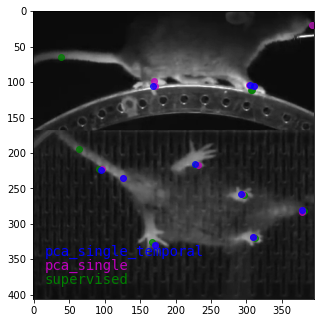

In [8]:
# video_name = "180605_000.short"
# # video_name = "180623_005.short"

# results_dir1 = "/media/mattw/behavior/results/pose-estimation/mirror-mouse-1"
# results_dir2 = "/media/mattw/behavior/results/pose-estimation/mirror-mouse-1.5"
# combo_name = 'pca_compare'

# video = "/media/mattw/behavior/pose-estimation-data/mirror-mouse-1.5/videos-short/%s.mp4" % video_name

# # fill csv files
# csvs = [
#     os.path.join(results_dir1, "2022-03-28/17-41-33/video_predictions/%s_predictions.csv" % video_name),
#     os.path.join(results_dir2, "2022-03-28/18-37-53/video_predictions/%s_predictions.csv" % video_name),
# ]
combo_name = "compare_pca_w_temporal"
video_name = "180727_001.mp4"
video = "/home/jovyan/clips/%s" % video_name
assert(os.path.exists(video))
csvs = ["/home/jovyan/pred_vids/180727_001_heatmap.csv","/home/jovyan/pred_vids/180727_001_heatmap_pca_singleview_7.250.csv","/home/jovyan/pred_vids/180727_001_heatmap_temporal_7.5_pca_singleview_7.25.csv"]

for csv in csvs:
    assert os.path.exists(csv)

model_names = ["supervised", "pca_single", "pca_single_temporal"]

points = []
for csv in csvs:
    xs, ys, ls, marker_names = load_marker_csv(csv)
    points_tmp = {}
    for m, marker_name in enumerate(marker_names):
        points_tmp[marker_name] = np.concatenate([
            xs[:, m, None], ys[:, m, None], ls[:, m, None]], axis=1)
    points.append(points_tmp)

cap = cv2.VideoCapture(video)

save_file = video.replace(".mp4", "%s.mp4" % combo_name)
make_labeled_video(save_file, cap, points, model_names, framerate=20, height=4)